In [0]:
from google.colab import drive
import os
import pandas as pd
import random
!pip install python-igraph
!pip install cairocffi
import igraph
from igraph import *
import cairocffi
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

drive.mount('/content/drive')
path = '/content/drive/My Drive'
os.chdir(path)
os.listdir(path)

In [0]:
def load_data():

    travel = pd.read_csv('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
    travel = travel[travel['month'] == 12]
    with open('los_angeles_censustracts.json') as f:
        geo = json.load(f)
    geo = geo['features']

    return travel, geo

def load_graph(tt, gb, directed=False):
    num_v = len(gb)
    # 1. Weighted undirected graph
    ttg = Graph()
    ttg.es['weight'] = 1.0
    ttg.is_weighted()
    if (directed):
        ttg = ttg.as_directed()

    # 2. Add vertices
    for v in range(num_v):
        vn = str(v+1)
        ttg.add_vertex(vn)
        pa = gb[v]['geometry']['coordinates']
        mp = np.array(sum(sum(pa,[]),[])).reshape(-1, 2)
        ttg.vs[v]['mean_plg'] = np.mean(mp, axis=0)
        

    # 3. Add edges (only Decemeber)
    s = tt['sourceid']
    d = tt['dstid']
    es = np.array([s, d]).T - 1
    ws = np.array(tt['mean_travel_time'])
    ttg.add_edges(es)
    ttg.es['weight'] = ws

    # 4. Simplify with average weight
    ttg.simplify(combine_edges='mean')

    # 5. Get largest connected component
    ttg = ttg.clusters().giant()
    
    return ttg

# Distance between two locations
def distance(graph, id1, id2):
    cor1 = graph.vs[id1]['mean_plg']
    cor2 = graph.vs[id2]['mean_plg']
    d = np.sqrt((cor1[0]-cor2[0])**2 + (cor1[1]-cor2[1])**2)*69
    return d

In [0]:
# Generate graph
tt, gb = load_data()
ttg = load_graph(tt, gb)

In [0]:
# Q6
print('Number of nodes:', ttg.vcount())
print('Number of edges:', ttg.ecount())

Number of nodes: 2649
Number of edges: 1003858


In [0]:
# Q7
ttg_mst = ttg.spanning_tree(weights=ttg.es['weight'])

for i in range(10):
    idx = random.randint(0,2648)
    edge = ttg_mst.es[idx]
    d = distance(ttg_mst, edge.source, edge.target)
    print("Start point: ", edge.source_vertex['id'])
    print("End point: ", edge.target_vertex['id'])
    print("Physical distance:", d)
    print()

Start point:  254
End point:  455
Physical distance: 0.5269012974310919

Start point:  285
End point:  1801
Physical distance: 0.5128239433630039

Start point:  1534
End point:  1538
Physical distance: 0.7794995262089565

Start point:  1294
End point:  1295
Physical distance: 0.26173699184438465

Start point:  1812
End point:  2275
Physical distance: 0.6850014559787228

Start point:  471
End point:  2232
Physical distance: 2.073715125281894

Start point:  2293
End point:  2303
Physical distance: 2.278539754490432

Start point:  1940
End point:  1941
Physical distance: 0.46374756984302684

Start point:  1926
End point:  1928
Physical distance: 0.8797797594457324

Start point:  111
End point:  112
Physical distance: 0.5039138688185256



In [0]:
# Q8
def frac_ti(ttg, number=1000):
    vn = ttg.vs['name']
    ti = 0

    tri_set = set()
    for idx in range(number):
        v_set = set()
        while(True):
            v_set = set(np.random.choice(vn, 3))

            if (len(v_set) != 3):
                continue

            v_li = tuple(np.sort(list(v_set)))
            
            if (v_set in tri_set):
                continue
              
            v1 = v_li[0]
            v2 = v_li[1]
            v3 = v_li[2]
            tri_set.add(v_li)
            d12 = dist(ttg, v1, v2)
            d21 = dist(ttg, v2, v1)
            d13 = dist(ttg, v1, v3)
            d31 = dist(ttg, v3, v1)
            d23 = dist(ttg, v2, v3)
            d32 = dist(ttg, v3, v2)
            if(d12 <= (d13+d32) and d13 <= (d12+d23) and d23 <= (d21+d13) and d21 <= (d23+d31) and d31 <= (d32+d21) and d32 <= (d31+d12)):
                ti += 1
            break
    
    return ti/number
    

def dist(g, v1, v2):
    v_li = g.get_shortest_paths(v1, v2)
    length = len(v_li[0])
    d = 0
    for idx in range(1, length):
        d += g[v_li[0][idx-1], v_li[0][idx]]
    return d

In [10]:
print('Fraction of triangles satisfying the triangle inequality of 1000 random samples:', frac_ti(ttg))

Fraction of triangles satisfying the triangle inequality of 1000 random samples: 0.877


In [0]:
# Q9
# Helpful functions
def create_a_walk(mst, walk, visited, mst_vset):
    current_node = walk[-1]
    
    if len(walk) > 1 and current_node == walk[0]: return True
    else:
        edges = mst.es.select(_between = ([current_node],mst_vset))
    
        for edge in edges:
            if not edge in visited:
                visited.add(edge)
                node_tuple = edge.tuple

                if node_tuple[0] == current_node:
                    next_node = node_tuple[1]
                else:
                    next_node = node_tuple[0]

                walk.append(next_node)
                next_walk = create_a_walk(mst, walk, visited, mst_vset)
                if next_walk:
                    return True
                else:
                    walk.pop()
                    visited.remove(edge)
                    
        return False

def eulerian_walk(mst, v, mst_vset):
    edges = mst.es.select(_source_in = [v])
    
    if len(edges) == 0: return [v] 
    else:
        walk = [v]
        visited = set()
        create_a_walk(mst, walk, visited, mst_vset)
        for i in range(len(walk) - 1):
            walk_edges = mst.es.select(_between = ([walk[i]], [walk[i+1]]))
            mst.delete_edges(walk_edges[0])
            
        results = []
        for node in walk:
            next_ewalk = eulerian_walk(mst, node, mst_vset)
            for e in next_ewalk:
                results.append(e)
                
        return results

def approx_algo(g):
    # MST
    mst = g.spanning_tree(weights = g.es["weight"])
    edges = mst.es()
    
    # Create a multigraph G by using two copies of each edge of T
    edge_list = []
    for edge in edges:
        edge_list.append(edge.tuple)
        
    mst_temp = mst.as_undirected() 
    mst_temp.add_edges(edge_list)
    
    mst_double = mst_temp.as_undirected()

    # Find an Eulerian walk of G and an embedded tour.
    e_walk = eulerian_walk(mst_double, 0, mst_double.vs())
    
    path = []
    visited = set()
    for i in e_walk:
        if not i in visited:
            path.append(i)
            visited.add(i)
            
    total_weight = 0
    final_path = []
    for i in range(len(path) - 1):
        i_1 = path[i]
        i_2 = path[i + 1]
        
        edges = g.es.select(_between = ([i_1], [i_2]))
        if len(edges) > 0:
            total_weight += edges[0]['weight']
            final_path.append(i_1)
        else:
            total_weight += ttg.shortest_paths([i_1], [i_2], weights = ttg.es()['weight'])[0][0]

    return mst, total_weight, final_path

In [57]:
import sys
sys.setrecursionlimit(10000)

mst, total_weight, final_path = approx_algo(ttg)
print('Approximate TSP cost:', total_weight)
print('Optimal TSP cost:', sum(mst.es['weight']))
print('Upper bound:', total_weight / sum(mst.es['weight']))

Approximate TSP cost: 455586.8949999996
Optimal TSP cost: 269084.5449999994
Upper bound: 1.6930994494685698


In [0]:
# Q10
x = []
y = []
for i in final_path:
    coor = mst.vs[i]['mean_plg']
    x.append(coor[1])
    y.append(coor[0])

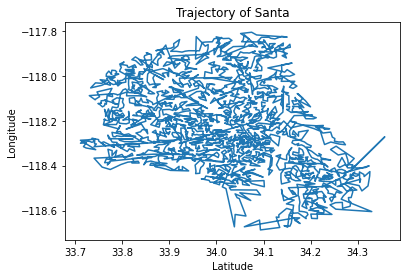

In [0]:
plt.plot(x, y)
plt.title('Trajectory of Santa')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

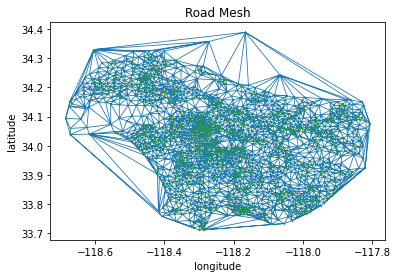

In [4]:
# Q11
from scipy.spatial import Delaunay
mean_plg = np.array(ttg.vs['mean_plg'])
tri = Delaunay(mean_plg)
plt.triplot(mean_plg[:,0], mean_plg[:,1], tri.simplices, linewidth=0.8)
plt.plot(mean_plg[:,0], mean_plg[:,1], '.', markersize=1)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh')
plt.show()

In [0]:
# Generate GΔ
# Generate edge
edge_list=[]
for idx in tri.simplices:
    edge_list.append([ttg.vs[idx[0]]['id'],ttg.vs[idx[1]]['id']])
    edge_list.append([ttg.vs[idx[1]]['id'],ttg.vs[idx[2]]['id']])
    edge_list.append([ttg.vs[idx[0]]['id'],ttg.vs[idx[2]]['id']])

In [6]:
G_delta = Graph()
G_delta = Graph.TupleList(edges = edge_list, directed=False, vertex_name_attr='name', edge_attrs=None, weights=False)
G_delta.simplify()

In [8]:
plot(G_delta, vertex_size = 4, bbox=(400,400))

In [0]:
# Add some useful attributes
loc = []
Tract = []
idx_ttg = []
for G_v in G_delta.vs:
    for idx in range(ttg.vcount()):
        ttg_v = ttg.vs[idx]
        if (ttg_v['id'] == G_v['name']):
            loc.append(ttg_v['mean_plg'])
            Tract.append(ttg_v['Tract'])
            idx_ttg.append(idx)
            continue

In [0]:
G_delta.vs['mean_plg'] = loc
G_delta.vs['Tract'] = Tract
G_delta.vs['idx_ttg'] = idx_ttg

In [0]:
ds = []
times = []
avg_speeds = []
flows = []
for edge in G_delta.es:
    d = distance(G_delta, edge.source, edge.target)

    # Use shortest path in ttg as time
    source_id_ttg = edge.source_vertex['idx_ttg']
    target_id_ttg = edge.target_vertex['idx_ttg']
    time = ttg.shortest_paths(source_id_ttg, target_id_ttg, weights=ttg.es['weight'], mode=OUT)[0][0]
    avg_speed = d/time
    flow = 7200*avg_speed/(0.003+2*avg_speed)

    ds.append(d)
    times.append(time)
    avg_speeds.append(avg_speed)
    flows.append(flow)

In [0]:
G_delta.es['weight'] = times # Use shortest path(time) in ttg as weight
G_delta.es['distance'] = ds
G_delta.es['avg_speed'] = avg_speeds  # miles/second
G_delta.es['flow'] = flows # cars/hour

In [29]:
print('Number of nodes:', G_delta.vcount())
print('Number of edges:', G_delta.ecount())

Number of nodes: 2649
Number of edges: 7927


In [0]:
# Q13
# Malibu: (name)1711,2649 (idx)3,4
# Long Beach: name = 675, idx = 667

# Find id of Malibu and Long Beach
for idx in range(G_delta.vcount()):
    if (G_delta.vs[idx]['Tract'] == '576601'):
        print(idx)
        print(G_delta.vs[idx]['name'])
        print(G_delta.vs[idx]['mean_plg'])

print()
for idx in range(G_delta.vcount()):
    if (G_delta.vs[idx]['Tract'] == '800504'):
        print(idx)
        print(G_delta.vs[idx]['name'])
        print(G_delta.vs[idx]['mean_plg'])

In [0]:
# Distance between two locations
def distance(graph, id1, id2):
    cor1 = graph.vs[id1]['mean_plg']
    cor2 = graph.vs[id2]['mean_plg']
    d = np.sqrt((cor1[0]-cor2[0])**2 + (cor1[1]-cor2[1])**2)*69
    return d

In [0]:
# Max flow
max_flow = G_delta.maxflow(3, 667, capacity = G_delta.es['flow'])
max_flow.value

15611.613312595875

In [20]:
# Number of edge-disjoint paths
G_delta.edge_disjoint_paths(3, 667)

6

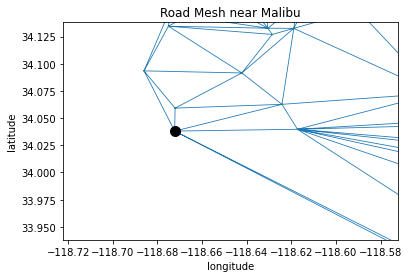

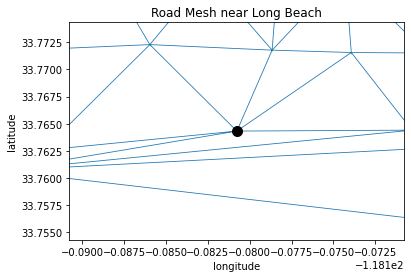

In [22]:
# Zoom in graph
Malibu_loc = G_delta.vs[3]['mean_plg']
LB_loc = G_delta.vs[667]['mean_plg']

plt.triplot(mean_plg[:,0], mean_plg[:,1], tri.simplices.copy(), linewidth=0.8)
plt.plot(mean_plg[:,0], mean_plg[:,1], '.', markersize=1)
plt.plot(Malibu_loc[0],Malibu_loc[1],'k.',ms=20)
plt.xlim((Malibu_loc[0]-0.05,Malibu_loc[0]+0.10))
plt.ylim((Malibu_loc[1]-0.10,Malibu_loc[1]+0.10))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh near Malibu')
plt.show()

plt.triplot(mean_plg[:,0], mean_plg[:,1], tri.simplices.copy(), linewidth=0.8)
plt.plot(mean_plg[:,0], mean_plg[:,1], '.', markersize=1)
plt.plot(LB_loc[0],LB_loc[1],'k.',ms=20)
plt.xlim((LB_loc[0]-0.01,LB_loc[0]+0.01))
plt.ylim((LB_loc[1]-0.01,LB_loc[1]+0.01))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh near Long Beach')
plt.show()

In [0]:
# Q14
# Prune Your Graph
G_delta_prune = G_delta.copy()
for edge in G_delta_prune.es:
    if (edge['weight']>720):
        G_delta_prune.delete_edges(edge)

In [43]:
print('Number of nodes:', G_delta_prune.vcount())
print('Number of edges:', G_delta_prune.ecount())

Number of nodes: 2649
Number of edges: 7879


In [0]:
# Get coordinates
mean_plg_prune = G_delta_prune.vs['mean_plg']

x = []
y = []
for plg in mean_plg_prune:
    x.append(plg[1])
    y.append(plg[0])

In [46]:
layout_obj = []
for idx in range(len(x)):
    layout_obj.append((x[idx],y[idx]))
print(layout_obj)

[(34.09155097353136, -118.64214877275657), (34.134544344919796, -118.67506014705866), (34.09347549818183, -118.68599468727271), (34.03809095384618, -118.67225393333337), (34.05920645953242, -118.67206896942434), (33.85066454285714, -117.89753402857143), (33.827645066666655, -117.91592312222224), (33.92345078723404, -117.8198295132979), (33.95697437647059, -117.82560231764704), (33.92170087223584, -117.83861802211293), (34.35782482248528, -118.27158981797648), (34.38948489307656, -118.16620295644888), (34.33016152360043, -118.60443423819959), (34.32570342045455, -118.44574180681816), (34.06269522170691, -118.62418590723568), (34.03975774911659, -118.61724170318024), (34.07289098425196, -118.55510068503939), (34.17777868656717, -118.65761208955222), (34.23432578378378, -118.62995530630634), (34.15606311194029, -117.85992133582091), (34.15019838461539, -117.82790007357855), (34.242974950043056, -118.06647650215321), (34.15698468864466, -117.8732378168498), (33.80353403636363, -117.9385431

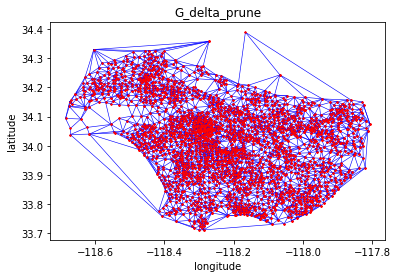

In [47]:
for edge in G_delta_prune.es:
    x = [edge.source_vertex['mean_plg'][0], edge.target_vertex['mean_plg'][0]]
    y = [edge.source_vertex['mean_plg'][1], edge.target_vertex['mean_plg'][1]]
    plt.plot(x, y,'o-', markersize=1, mec = 'red', color='blue', linewidth=0.6)

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('G_delta_prune')
plt.show()

In [48]:
# Q15
# Max flow
max_flow_prune = G_delta_prune.maxflow(3, 667, capacity = G_delta_prune.es['flow'])
max_flow_prune.value

11368.409857125307

In [49]:
# Number of edge-disjoint paths
G_delta_prune.edge_disjoint_paths(3, 667)

4

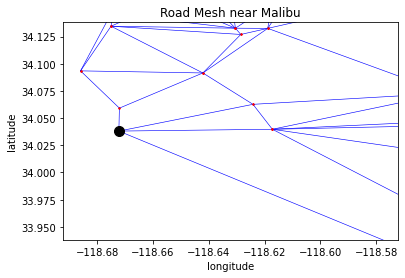

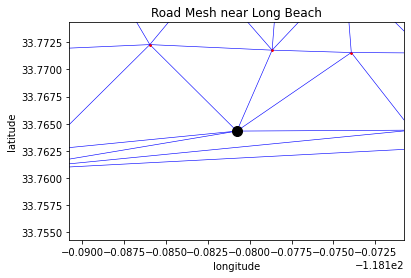

In [54]:
# Zoom in graph
Malibu_loc = G_delta_prune.vs[3]['mean_plg']
LB_loc = G_delta_prune.vs[667]['mean_plg']

for edge in G_delta_prune.es:
    x = [edge.source_vertex['mean_plg'][0], edge.target_vertex['mean_plg'][0]]
    y = [edge.source_vertex['mean_plg'][1], edge.target_vertex['mean_plg'][1]]
    plt.plot(x, y,'o-', markersize=1, mec = 'red', color='blue', linewidth=0.6)

plt.plot(Malibu_loc[0],Malibu_loc[1],'k.',ms=20)
plt.xlim((Malibu_loc[0]-0.02,Malibu_loc[0]+0.10))
plt.ylim((Malibu_loc[1]-0.10,Malibu_loc[1]+0.10))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh near Malibu')
plt.show()

for edge in G_delta_prune.es:
    x = [edge.source_vertex['mean_plg'][0], edge.target_vertex['mean_plg'][0]]
    y = [edge.source_vertex['mean_plg'][1], edge.target_vertex['mean_plg'][1]]
    plt.plot(x, y,'o-', markersize=1, mec = 'red', color='blue', linewidth=0.6)
    
plt.plot(LB_loc[0],LB_loc[1],'k.',ms=20)
plt.xlim((LB_loc[0]-0.01,LB_loc[0]+0.01))
plt.ylim((LB_loc[1]-0.01,LB_loc[1]+0.01))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh near Long Beach')
plt.show()

**Define own task:**

Take the Uber data again from December 2019, but generate a directed graph this time. Similarly, we will only keep the largest connected component for simplicity. The goal is to solve the TSP problem for the directed graph (Asymmetric TSP, or ATSP).

In [0]:
# Load graph: directed graph
ttgd = load_graph(tt, gb, True)

In [61]:
print('Number of nodes:', ttgd.vcount())
print('Number of edges:', ttgd.ecount())

Number of nodes: 2639
Number of edges: 1690440


1. Test triangle inequality

In [62]:
print('Fraction satisfying the triangle inequality of 1000 random samples (directed graph):', frac_ti(ttgd))

Fraction satisfying the triangle inequality of 1000 random samples (directed graph): 0.781


2. Due to the high fraction satisfying triangle inequality, we could assume it true for the whole graph. Therefore, we could assume the graph satisfies the triangle inequality, to solve the ATSP.

In [0]:
def get_bipartite(g1):
    num_vg = g1.vcount()
    # 1. Bipartite graph
    g2 = Graph()
    g2.es['weight'] = 1.0
    g2.is_weighted()
    # Create dual vertices
    orig_vs = [v['name'] for v in g1.vs()]
    dual_vs = ['d'+v for v in orig_vs]
    new_vs = list(orig_vs)
    new_vs.extend(dual_vs)
    g2.add_vertices(new_vs)
    types = [0 for idx in range(num_vg)]
    types.extend([1 for idx in range(num_vg)])
    g2.vs['type'] = types
    # Add edges
    orig_es = g1.get_edgelist()
    new_es = np.array(orig_es)
    new_es[:, 1] += num_vg
    g2.add_edges(new_es)
    ws = g1.es['weight']
    g2.es['weight'] = ws

    return g2

def cycle_cover(g1):
    num_vg = g1.vcount()
    g2 = get_bipartite(g1)
    mm = g2.maximum_bipartite_matching()
    cycle_cover = []
    for e in mm.edges():
        v1 = e.source_vertex['name']
        v2 = e.target_vertex['name']
        v2 = v2[1:]
        cycle_cover.append((v1, v2))
    return cycle_cover



def ATSP(gd):
    gc = gd.copy()
    ws = []
    vs = gc.vs['name']

    tour = Graph()
    tour = tour.as_directed()
    tour.add_vertices(vs)

    cc = cycle_cover(gc)
    tour.add_edges(cc)
    eids = gc.get_eids(cc)
    ws = gc.es.select(eids)['weight']
    tg = gc.copy()
    tg.delete_edges(gc.get_edgelist())
    tg.add_edges(cc)
    tg.es['weight'] = ws
    tour.es['weight']= ws

    vss = []
    ves = []
    for cl in tg.clusters():
        vs = [tg.vs[v]['name'] for v in cl]
        v1 = vs[0]
        v2 = None
        for v in vs:
            if tour.are_connected(v1, v):
                v2 = v
        e = tour.get_eid(v1, v2)
        tour.delete_edges(e)
        vss.append(v1)
        ves.append(v2)
    
    for idx in range(1, len(vss)):
        v1 = vss[idx-1]
        v2 = ves[idx]

        rp = gc.get_shortest_paths(v=v1, to=v2, weights=gc.es['weight'])[0]
        rp = [gc.vs[idx]['name'] for idx in rp]
        l1 = rp[:-1]
        l2 = rp[1:]
        for idx in range(len(l1)):
            e1 = l1[idx]
            e2 = l2[idx]
            eid = gc.get_eid(e1, e2)
            w = gc.es['weight'][eid]
            tour.add_edge(e1, e2, weight=w)
        
    v1 = vss[-1]
    v2 = ves[0]
    rp = gc.get_shortest_paths(v=v1, to=v2, weights=gc.es['weight'])[0]
    rp = [gc.vs[idx]['name'] for idx in rp]
    l1 = rp[:-1]
    l2 = rp[1:]
    for idx in range(len(l1)):
        e1 = l1[idx]
        e2 = l2[idx]
        eid = gc.get_eid(e1, e2)
        w = gc.es['weight'][eid]
        tour.add_edge(e1, e2, weight=w)

    return tour   

In [0]:
tour = ATSP(ttgd)

3. Result

In [0]:
total_cost = np.sum(tour.es['weight'])
print('Original graph has:', ttgd.vcount(), 'nodes and', ttgd.ecount(), 'edges')
print('The approximated optimal tour has:', tour.vcount(), 'nodes and', tour.ecount(), 'edges')
print('The approximated total cost is:', total_cost)
print('Test for strongly-connectedness: ', tour.clusters().giant().ecount() == tour.ecount())


Original graph has: 2639 nodes and 1690440 edges
The approximated optimal tour has: 2639 nodes and 3048 edges
The approximated total cost is: 1436792.5
Test for strongly-connectedness:  True


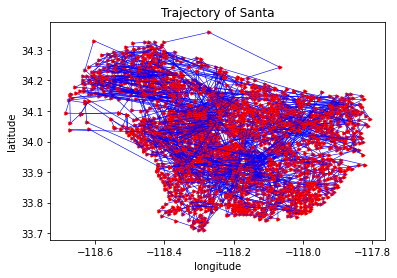

In [17]:
for edge in tour.es:  
    source_coor = ttgd.vs[edge.source]['mean_plg']
    target_coor = ttgd.vs[edge.target]['mean_plg']
    x = [source_coor[0], target_coor[0]]
    y = [source_coor[1], target_coor[1]]
    plt.plot(x, y,'->', markersize=3, mec = 'red', color='blue', linewidth=0.6)
    
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Trajectory of Santa')
plt.show()